In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text


In [2]:
HOST = "172.18.0.7"
PORT = "5435"
USER = "moodle_sink"
PASS = "psqlpassword"
DB = "sink"
CONNECTION_STR = f"postgresql+psycopg2://{USER}:{PASS}@{HOST}/{DB}"
ENGINE = create_engine(CONNECTION_STR)




In [3]:
with ENGINE.connect() as conn:
    select_sites_users = 'SELECT * FROM "SitesUsers";'
    sites_users = pd.read_sql(sql=select_sites_users, con=conn)#, parse_dates=['registration_timestamp'])
    select_community_users = 'SELECT * FROM "CommunityUsers";'
    community_users = pd.read_sql(sql=select_community_users, con=conn)#, parse_dates=['registration_timestamp'])

In [4]:
sites_users['registration_timestamp'] = pd.to_datetime(sites_users['registration_timestamp'], unit="s")
community_users['registration_timestamp'] = pd.to_datetime(community_users['registration_timestamp'], unit="s")


# Data info

In [5]:
sites_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      1000 non-null   int64         
 1   username                1000 non-null   object        
 2   fullname                1000 non-null   object        
 3   admin_email             1000 non-null   object        
 4   registration_timestamp  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 39.2+ KB


In [6]:
community_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11518 entries, 0 to 11517
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      11518 non-null  int64         
 1   username                11518 non-null  object        
 2   fullname                11518 non-null  object        
 3   email                   11518 non-null  object        
 4   registration_timestamp  11518 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 450.0+ KB


In [7]:
sites_users.head()

,id,username,fullname,admin_email,registration_timestamp
0,1,brettwilkins,Kevin Horton,ericharris@hotmail.com,2010-04-14 21:23:29
1,2,dmiller,Jamie Brown,ahill@gmail.com,2011-07-08 17:07:04
2,3,susanberry,Todd Clements,ronald73@gmail.com,2010-12-10 15:13:16
3,4,mbrown,Dr. Stephanie Martin,kathrynhamilton@gmail.com,2015-11-11 10:54:44
4,5,lreyes,Belinda Hernandez,rebeccasoto@yahoo.com,2015-07-30 11:54:58


In [8]:
sites_users['year'] = sites_users['registration_timestamp'].dt.year
community_users['year'] = community_users['registration_timestamp'].dt.year

<AxesSubplot: title={'center': 'Site Users Count Per Year'}, xlabel='year', ylabel='Users Count'>

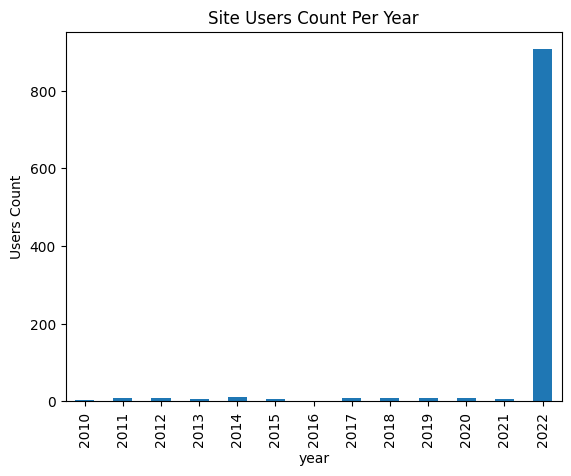

In [9]:
sites_users.groupby("year")["admin_email"].count().plot(kind="bar", title="Site Users Count Per Year", ylabel="Users Count")


<AxesSubplot: title={'center': 'Community Users Count Per Year'}, xlabel='year', ylabel='Users Count'>

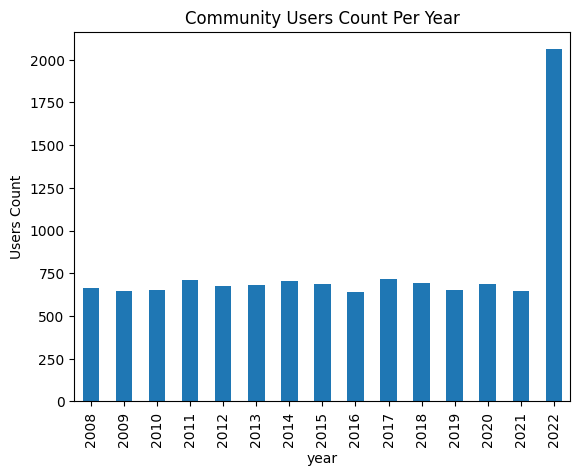

In [10]:
community_users.groupby("year")["email"].count().plot(kind="bar", title="Community Users Count Per Year", ylabel="Users Count")


In [11]:
sites_users['email'] = sites_users['admin_email']

In [12]:
fourm_member_admins = sites_users[sites_users['admin_email'].isin(community_users['email'])]

In [13]:
fourm_member_admins.shape

(36, 7)

In [14]:
fourm_member_admins

,id,username,fullname,admin_email,registration_timestamp,year,email
6,7,matthewbryan,Brandon Lopez,ymorris@yahoo.com,2015-12-14 06:34:47,2015,ymorris@yahoo.com
12,13,diana77,Clarence Gregory,jordankaren@gmail.com,2021-06-30 23:07:06,2021,jordankaren@gmail.com
149,150,twhite,Scott Lewis,michaelreed@hotmail.com,2022-09-07 05:13:24,2022,michaelreed@hotmail.com
152,153,rcook,Francisco Olson,jjohnson@yahoo.com,2022-09-14 06:50:21,2022,jjohnson@yahoo.com
176,177,christopher15,Paul Mann,itaylor@yahoo.com,2022-09-12 09:41:45,2022,itaylor@yahoo.com
203,204,carl12,Allison Garcia,hfrost@gmail.com,2022-09-04 08:38:38,2022,hfrost@gmail.com
245,246,danielbaker,Walter Haynes,elizabeth70@yahoo.com,2022-09-29 14:39:24,2022,elizabeth70@yahoo.com
248,249,alexisstewart,Kimberly Moreno,lwilliams@gmail.com,2022-09-05 19:27:09,2022,lwilliams@gmail.com
274,275,jay48,Melissa Price,mmartinez@gmail.com,2022-09-28 08:08:31,2022,mmartinez@gmail.com
305,306,mendozaantonio,Amanda Marshall,richardsdouglas@hotmail.com,2022-09-08 02:38:05,2022,richardsdouglas@hotmail.com


<AxesSubplot: title={'center': 'Site Admins that are also community users'}, xlabel='year', ylabel='count'>

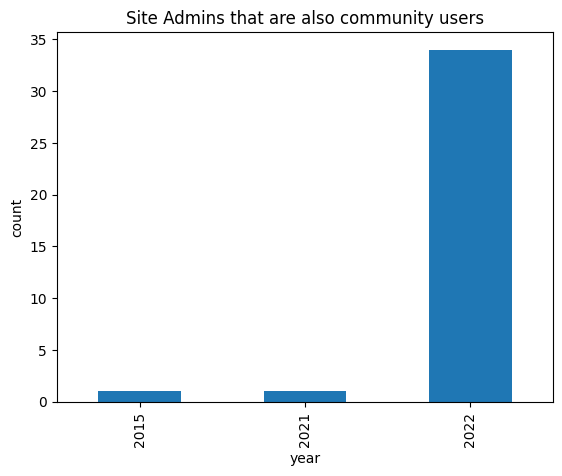

In [15]:
fourm_member_admins.groupby("year")["admin_email"].count().plot(kind="bar", title="Site Admins that are also community users", ylabel="count")